# FIT5202 Data processing for big data

##  Activity: Machine Learning with Spark (Transformer, Estimator and Pipeline API)

This week we are going to learn about machine learning with Apache Spark. **``MLlib``** is Apache Spark's scalable machine learning library. Its goal is to make practical machine learning scalable and easy. At a high level, it provides tools such as:

- ML Algorithms: common learning algorithms such as classification, regression, clustering, and collaborative filtering
- Featurization: feature extraction, transformation, dimensionality reduction, and selection
- Pipelines: tools for constructing, evaluating, and tuning ML Pipelines
- Persistence: saving and load algorithms, models, and Pipelines
- Utilities: linear algebra, statistics, data handling, etc.

This week we are going to learn about transformers, estimators and machine learning pipeline in this tutorial activity.



## Table of Contents

* [Initialize SparkSession](#one)
* [Problem Statement](#problem-statement)
* [Data Loading and Exploration](#data-loading)
* [Transformers and Estimators](#estimators)
    * [StopWordsRemover](#stop-words)
    * [StringIndexer](#string-indexer)        
    * [OneHotEncoder](#ohe)
    * [VectorAssembler](#vector-assembler)
    * [ML Algorithm and Prediction](#ml-algorithm)
* [Pipeline API](#pipeline)
    * [Pipeline API Example](#pipeline-example)
* [Testing with real data](#testing)
* [Lab Tasks](#lab-task-1)
    * [Lab Task 1](#lab-task-1)
    * [Lab Task 2](#lab-task-2)
    * [Lab Task 3](#lab-task-3)    
    * [Lab Task 4](#lab-task-4)

## Initialize Spark Session <a class="anchor" id="one"></a>


<div style="background:rgba(0,109,174,0.2);padding:10px;border-radius:4px"><strong style="color:#006DAE">TODO: </strong>In the cell block below, 
<ul>
    <li>Create a SparkConfig object with application name set as "Spark ML-Transformer, Estimator and Pipeline"</li>
    <li>specify 2 cores for processing</li>
    <li>Use the configuration object to create a spark session named as <strong>spark</strong>.</li>
    </ul>
    
<p><strong style="color:red">Important:</strong> You cannot proceed to other steps without completing this.</p>
</div>

In [1]:
# TODO: Import libraries needed from pyspark

# TODO: Create Spark Configuration Object

# TODO: Create SparkSession
# Import SparkConf class into program
from pyspark import SparkConf

# local[*]: run Spark in local mode with as many working processors as logical cores on your machine
# If we want Spark to run locally with 'k' worker threads, we can specify as "local[k]".
master = "local[*]"
# The `appName` field is a name to be shown on the Spark cluster UI page
app_name = "Intro to ML"
# Setup configuration parameters for Spark
spark_conf = SparkConf().setMaster(master).setAppName(app_name)

# Import SparkContext and SparkSession classes
from pyspark import SparkContext # Spark
from pyspark.sql import SparkSession # Spark SQL

# Method 1: Using SparkSession
spark = SparkSession.builder.config(conf=spark_conf).getOrCreate()
sc = spark.sparkContext
sc.setLogLevel('ERROR')


## Problem Statement <a class="anchor" id="problem-statement"></a>
<hr/>
Before we jumpstart coding, it is important to understand the problem and its context. The dataset we are using today is the popular <strong>Adult Income Dataset</strong>.[<a href="http://archive.ics.uci.edu/ml/datasets/Adult" target="_BLANK">Source</a>]
The dataset provides different parameters of an individual which might influence his/her income. 


<div style="background:rgba(0,109,174,0.2);padding:10px;border-radius:4px"><strong style="color:#006DAE">Objective:</strong> We want to explore and see if different personal attributes of a person influence his/her income and whether we can use these attributes to predict their income levels.</div>

### Machine Learning Flow
The figure below depicts the flow of the Machine Learning approach we want to take. The <strong>ML Algorithm</strong> we are going to use is <strong>Logistic Regression</strong>. Here, we are not going to get into details of the algorithm. We will look at these in details in coming tutorials.
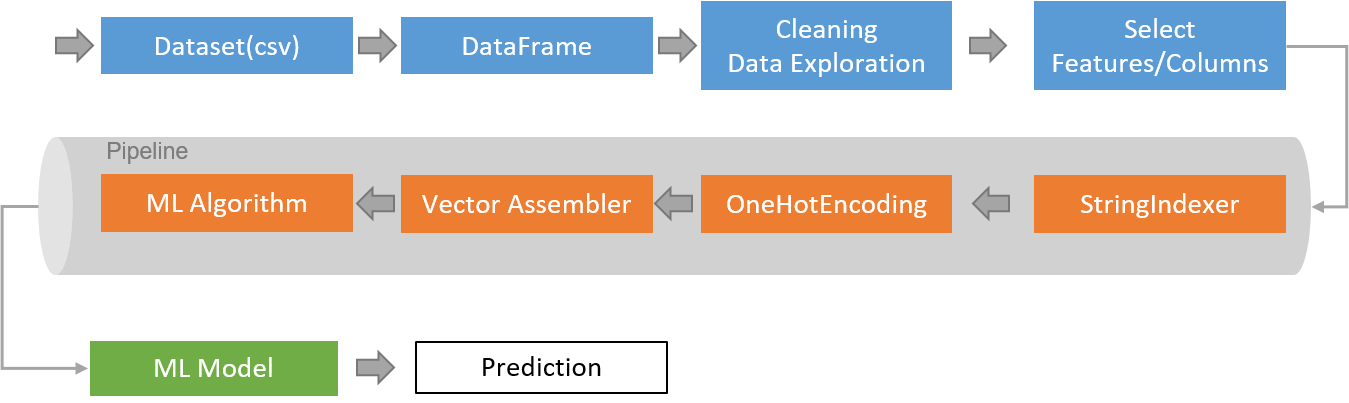

## Data Loading and Pre-processing and Exploration <a class="anchor" name="data-loading"></a>
In this step, we shall load the given <code>adult.csv</code> file, examine the data and some basic data cleaning operations like checking for null values and finally select a set of relevant columns for our analysis.


In [2]:
#Load the CSV File
df_adult = spark.read.format('csv')\
            .option('header',True).option('escape','"')\
            .load('adult.csv')

In [3]:
#Print the Schema
df_adult.printSchema()

root
 |-- age: string (nullable = true)
 |-- workclass: string (nullable = true)
 |-- fnlwgt: string (nullable = true)
 |-- education: string (nullable = true)
 |-- educational-num: string (nullable = true)
 |-- marital-status: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- capital-gain: string (nullable = true)
 |-- capital-loss: string (nullable = true)
 |-- hours-per-week: string (nullable = true)
 |-- native-country: string (nullable = true)
 |-- income: string (nullable = true)



<div style="background:rgba(0,109,174,0.2);padding:10px;border-radius:4px"><strong style="color:#006DAE">IMPORTANT:</strong> The <code>income</code> is our <strong>target variable</strong> also called <strong>label</strong> and we are going to use other <strong>independent</strong> variables to predict the target variable.</div>

In [4]:
#Check the shape of the dataframe
print((df_adult.count(), len(df_adult.columns)))

(48842, 15)


In [5]:
#Summary Statistics
df_adult.describe().show(5)

+-------+------------------+-----------+------------------+------------+------------------+--------------+----------------+------------+------------------+------+------------------+------------------+------------------+--------------+------+
|summary|               age|  workclass|            fnlwgt|   education|   educational-num|marital-status|      occupation|relationship|              race|gender|      capital-gain|      capital-loss|    hours-per-week|native-country|income|
+-------+------------------+-----------+------------------+------------+------------------+--------------+----------------+------------+------------------+------+------------------+------------------+------------------+--------------+------+
|  count|             48842|      48842|             48842|       48842|             48842|         48842|           48842|       48842|             48842| 48842|             48842|             48842|             48842|         48842| 48842|
|   mean| 38.64358543876172|    

In [6]:
# The function .head() returns the first n rows for the object based on position. Default n=5 
df_adult.describe().toPandas().head()

,summary,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,count,48842,48842,48842,48842,48842,48842,48842,48842,48842,48842,48842,48842,48842,48842,48842
1,mean,38.64358543876172,None,189664.13459727284,None,10.078088530363212,None,None,None,None,None,1079.0676262233324,87.50231358257237,40.422382375824085,None,None
2,stddev,13.710509934443518,None,105604.02542315758,None,2.570972755592256,None,None,None,None,None,7452.019057655418,403.00455212435924,12.391444024252296,None,None
3,min,17,?,100009,10th,1,Divorced,?,Husband,Amer-Indian-Eskimo,Female,0,0,1,?,<=50K
4,max,90,Without-pay,99987,Some-college,9,Widowed,Transport-moving,Wife,White,Male,99999,974,99,Yugoslavia,>50K


<div style="background:rgba(0,109,174,0.2);padding:10px;border-radius:4px"><strong style="color:#006DAE">TODO: </strong>
For better readability of dataframes, you can also convert the dataframe to a <strong>Pandas</strong> DataFrame. 
    <span style="color:red">Please note that, we can use this only if we have few rows, since the data is loaded into the driver node.</span>
    Try using <code>df_adult.describe().toPandas().head()</code>
    
<strong style="color:#FF5555">IMPORTANT: </strong>
    To use <code>.toPandas</code>, Pandas has to be installed. If not, please use <code>!pip install pandas</code> to install <strong>Pandas</strong> in Jupyter Notebook.
</div>



<div style="background:rgba(0,109,174,0.2);padding:10px;border-radius:4px"><strong style="color:#006DAE">Exploratory Analysis: </strong>
Data Exploration and visualization will be covered in the coming tutorials. Here we will focus on the Featurization part.
</div>


For simplicity, we are only considering a set of features from the dataset for our analysis. The columns we want to use are <code>'workclass','education','marital-status','occupation','relationship','race','gender','income'</code>. We are going to create a dataframe with these columns only and use this DataFrame for the rest of our analysis.

In [7]:
cols=['workclass','education','marital-status','occupation','relationship','race','gender','income']
df = df_adult[cols]
df.show(5)

+---------+------------+------------------+-----------------+------------+-----+------+------+
|workclass|   education|    marital-status|       occupation|relationship| race|gender|income|
+---------+------------+------------------+-----------------+------------+-----+------+------+
|  Private|        11th|     Never-married|Machine-op-inspct|   Own-child|Black|  Male| <=50K|
|  Private|     HS-grad|Married-civ-spouse|  Farming-fishing|     Husband|White|  Male| <=50K|
|Local-gov|  Assoc-acdm|Married-civ-spouse|  Protective-serv|     Husband|White|  Male|  >50K|
|  Private|Some-college|Married-civ-spouse|Machine-op-inspct|     Husband|Black|  Male|  >50K|
|        ?|Some-college|     Never-married|                ?|   Own-child|White|Female| <=50K|
+---------+------------+------------------+-----------------+------------+-----+------+------+
only showing top 5 rows



<a class="anchor" id="lab-task-1"></a>
<div style="background:rgba(0,109,174,0.2);padding:10px;border-radius:4px"><strong style="color:#FF5555">1. Lab Task: </strong>
    Examine the different unique values the <code>income</code> column has. Display the <code>distinct</code> values of the target variable i.e. the <code>income</code> column. 
</div>


In [8]:
df.select('income').distinct().show()

+------+
|income|
+------+
| <=50K|
|  >50K|
+------+



### Checking Missing/Null values
Check for missing data, drop the rows for missing data.<a href="https://www.datasciencemadesimple.com/count-of-missing-nanna-and-null-values-in-pyspark/" target="_BLANK">[Read More]</a>


In [9]:
# Count of both null (isNull()) and missing values (isnan) of dataframe in pyspark:
from pyspark.sql.functions import isnan, when, count, col
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+---------+---------+--------------+----------+------------+----+------+------+
|workclass|education|marital-status|occupation|relationship|race|gender|income|
+---------+---------+--------------+----------+------------+----+------+------+
|        0|        0|             0|         0|           0|   0|     0|     0|
+---------+---------+--------------+----------+------------+----+------+------+



## Estimators, Transformers and Pipelines <a class="anchor" name="estimators"></a>
<hr/>
Spark's machine learning library has three main abstractions.
<ol>
    <li><strong>Transformer:</strong> Takes dataframe as input and returns a new DataFrame with one or more columns appended to it. Implements a <code>.transform()</code> method.</li>
    <li><strong>Estimator:</strong> Takes dataframe as input and returns a model. Estimator learns from the data. It implements a <code>.fit()</code> method.</li>
    <li><strong>Pipeline:</strong> <strong>Combines</strong> together <code>transformers</code> and <code>estimators</code>. Pipelines implement a <code>.fit</code> method.</li>
</ol>

<div style="background:rgba(0,109,174,0.2);padding:10px;border-radius:4px"><strong style="color:#006DAE">NOTE: </strong>
    Spark appends columns to pre-existing <strong>immutable</strong> DataFrames rather than performing operations <strong>in-place</strong>.
</div>

### StopWordsRemover  <a class="anchor" name="stop-words"></a>
<code>StopWordsRemover</code> takes input as a sequence of strings and drops all stop words. Stop Words are the words that should be excluded from the input, because they appear frequently and don't carry much meaning.<a href="https://spark.apache.org/docs/latest/ml-features.html#stopwordsremover" target="_BLANK">[Ref]</a>

In [10]:
from pyspark.ml.feature import StopWordsRemover

sentenceData = spark.createDataFrame([
    (0, ["I", "saw", "the", "red", "balloon"]),
    (1, ["Mary", "had", "a", "little", "lamb"])
], ["id", "raw"])
sentenceData.show(truncate=False)


remover = StopWordsRemover(inputCol="raw", outputCol="filtered")
remover.transform(sentenceData).show(truncate=False)

stopwords = remover.getStopWords()
print(stopwords)

+---+----------------------------+
|id |raw                         |
+---+----------------------------+
|0  |[I, saw, the, red, balloon] |
|1  |[Mary, had, a, little, lamb]|
+---+----------------------------+

+---+----------------------------+--------------------+
|id |raw                         |filtered            |
+---+----------------------------+--------------------+
|0  |[I, saw, the, red, balloon] |[saw, red, balloon] |
|1  |[Mary, had, a, little, lamb]|[Mary, little, lamb]|
+---+----------------------------+--------------------+

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', '

In [11]:
remover = StopWordsRemover(inputCol="raw", outputCol="filtered",stopWords=["saw","red"])
remover.transform(sentenceData).show(truncate=False)

+---+----------------------------+----------------------------+
|id |raw                         |filtered                    |
+---+----------------------------+----------------------------+
|0  |[I, saw, the, red, balloon] |[I, the, balloon]           |
|1  |[Mary, had, a, little, lamb]|[Mary, had, a, little, lamb]|
+---+----------------------------+----------------------------+



### StringIndexer  <a class="anchor" name="string-indexer"></a>
<code>StringIndexer</code> encodes string columns as indices. It assigns a unique value to each category. We need to define the input column/columns name and the output column/columns name in which we want the results.<a href="https://spark.apache.org/docs/latest/ml-features.html#stringindexer" target="_BLANK">[Read More]</a>

 - The indices are in [0, numLabels)
 - Four ordering options are supported: Default: “frequencyDesc”: descending order by label frequency (most frequent label assigned 0)
 -The unseen labels will be put at index numLabels if user chooses to keep them.

In [12]:
from pyspark.ml.feature import StringIndexer

df_ref = spark.createDataFrame(
    [(0, "a"), (1, "b"), (2, "c"), (3, "a"), (4, "a"), (5, "c")],
    ["id", "category"])

indexer = StringIndexer(inputCol="category", outputCol="categoryIndex")
indexed_transformer = indexer.fit(df_ref)
indexed = indexed_transformer.transform(df_ref)
indexed.show()

+---+--------+-------------+
| id|category|categoryIndex|
+---+--------+-------------+
|  0|       a|          0.0|
|  1|       b|          2.0|
|  2|       c|          1.0|
|  3|       a|          0.0|
|  4|       a|          0.0|
|  5|       c|          1.0|
+---+--------+-------------+



#### How StringIndexer will handle unseen labels when you have fit a StringIndexer on one dataset and then use it to transform another
   - throw an exception (which is the default)
   - skip the row containing the unseen label entirely
   - put unseen labels in a special additional bucket, at index numLabels

In [13]:
df_unseen = spark.createDataFrame(
    [(0, "a"), (1, "b"), (2, "c"), (3, "d"), (4, "e")],
    ["id", "category"])
indexed_unseen = indexed_transformer.transform(df_unseen)
indexed_unseen.show()

Py4JJavaError: An error occurred while calling o276.showString.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 2 in stage 29.0 failed 1 times, most recent failure: Lost task 2.0 in stage 29.0 (TID 41) (739ab23373d4 executor driver): org.apache.spark.SparkException: Failed to execute user defined function (StringIndexerModel$$Lambda$4011/0x0000000801c35408: (string) => double)
	at org.apache.spark.sql.errors.QueryExecutionErrors$.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala:177)
	at org.apache.spark.sql.errors.QueryExecutionErrors.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:760)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$getByteArrayRdd$1(SparkPlan.scala:364)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2(RDD.scala:890)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2$adapted(RDD.scala:890)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:136)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:548)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1504)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:551)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	at java.base/java.lang.Thread.run(Thread.java:833)
Caused by: org.apache.spark.SparkException: Unseen label: d. To handle unseen labels, set Param handleInvalid to keep.
	at org.apache.spark.ml.feature.StringIndexerModel.$anonfun$getIndexer$1(StringIndexer.scala:406)
	at org.apache.spark.ml.feature.StringIndexerModel.$anonfun$getIndexer$1$adapted(StringIndexer.scala:391)
	... 17 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2672)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2608)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2607)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2607)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1182)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1182)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1182)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2860)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2802)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2791)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:952)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2228)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2249)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2268)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:506)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:459)
	at org.apache.spark.sql.execution.CollectLimitExec.executeCollect(limit.scala:48)
	at org.apache.spark.sql.Dataset.collectFromPlan(Dataset.scala:3868)
	at org.apache.spark.sql.Dataset.$anonfun$head$1(Dataset.scala:2863)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$2(Dataset.scala:3858)
	at org.apache.spark.sql.execution.QueryExecution$.withInternalError(QueryExecution.scala:510)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:3856)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:109)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:169)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:95)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:779)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:64)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3856)
	at org.apache.spark.sql.Dataset.head(Dataset.scala:2863)
	at org.apache.spark.sql.Dataset.take(Dataset.scala:3084)
	at org.apache.spark.sql.Dataset.getRows(Dataset.scala:288)
	at org.apache.spark.sql.Dataset.showString(Dataset.scala:327)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:77)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:568)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:833)
Caused by: org.apache.spark.SparkException: Failed to execute user defined function (StringIndexerModel$$Lambda$4011/0x0000000801c35408: (string) => double)
	at org.apache.spark.sql.errors.QueryExecutionErrors$.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala:177)
	at org.apache.spark.sql.errors.QueryExecutionErrors.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:760)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$getByteArrayRdd$1(SparkPlan.scala:364)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2(RDD.scala:890)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2$adapted(RDD.scala:890)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:136)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:548)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1504)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:551)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	... 1 more
Caused by: org.apache.spark.SparkException: Unseen label: d. To handle unseen labels, set Param handleInvalid to keep.
	at org.apache.spark.ml.feature.StringIndexerModel.$anonfun$getIndexer$1(StringIndexer.scala:406)
	at org.apache.spark.ml.feature.StringIndexerModel.$anonfun$getIndexer$1$adapted(StringIndexer.scala:391)
	... 17 more


In [14]:
## setHandleInvalid("skip")
# https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.feature.StringIndexer.html
indexer_skip = StringIndexer(inputCol="category", outputCol="categoryIndex",handleInvalid = "skip")
indexed_transformer_skip = indexer_skip.fit(df_ref)
indexed_unseen = indexed_transformer_skip.transform(df_unseen)
indexed_unseen.show()

+---+--------+-------------+
| id|category|categoryIndex|
+---+--------+-------------+
|  0|       a|          0.0|
|  1|       b|          2.0|
|  2|       c|          1.0|
+---+--------+-------------+



In [15]:
## setHandleInvalid("keep")
# https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.feature.StringIndexer.html
indexer_keep = StringIndexer(inputCol="category", outputCol="categoryIndex",handleInvalid = "keep")
indexed_transformer_keep = indexer_keep.fit(df_ref)
indexed_unseen = indexed_transformer_keep.transform(df_unseen)
indexed_unseen.show()

+---+--------+-------------+
| id|category|categoryIndex|
+---+--------+-------------+
|  0|       a|          0.0|
|  1|       b|          2.0|
|  2|       c|          1.0|
|  3|       d|          3.0|
|  4|       e|          3.0|
+---+--------+-------------+



##### Understanding Python List Comprehensions
The examples below use List Comprehensions in Python. You may frequently see this being used. You can read more about it <a href="https://www.programiz.com/python-programming/list-comprehension" target="_BLANK">here</a>.

In [16]:
# Getting column names from the dataframe 
inputCols=[x for x in df.columns]
print(inputCols)

# Note that we have used Python List Comprehension in the above example
#This is equivalent to doing 
inputCols=[]
for x in df.columns:
    inputCols.append(x)
print(inputCols)

['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'income']
['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'income']


<a class="anchor" id="lab-task-2"></a>
<div style="background:rgba(0,109,174,0.2);padding:10px;border-radius:4px"><strong style="color:#FF5555">2. Lab Task: </strong> Use <code>StringIndexer</code> to encode all the columns from the DataFrame <code>df</code> we created in the previous step. <em>Since all the columns we have are categorical in nature, we want to use <code>StringIndexer</code> to transform them into numerical values.</em>
<div style="background:rgba(0,109,174,0.2);padding:10px;border-radius:4px"><strong style="color:#006DAE">NOTE: </strong>
    You can pass multiple columns as input and output in <code>StringIndexer</code> using <code>StringIndexer(inputCols=["col1","col2"], outputCols=["col1Index","col2Index"])</code>
</div>
</div>

### Expected output:
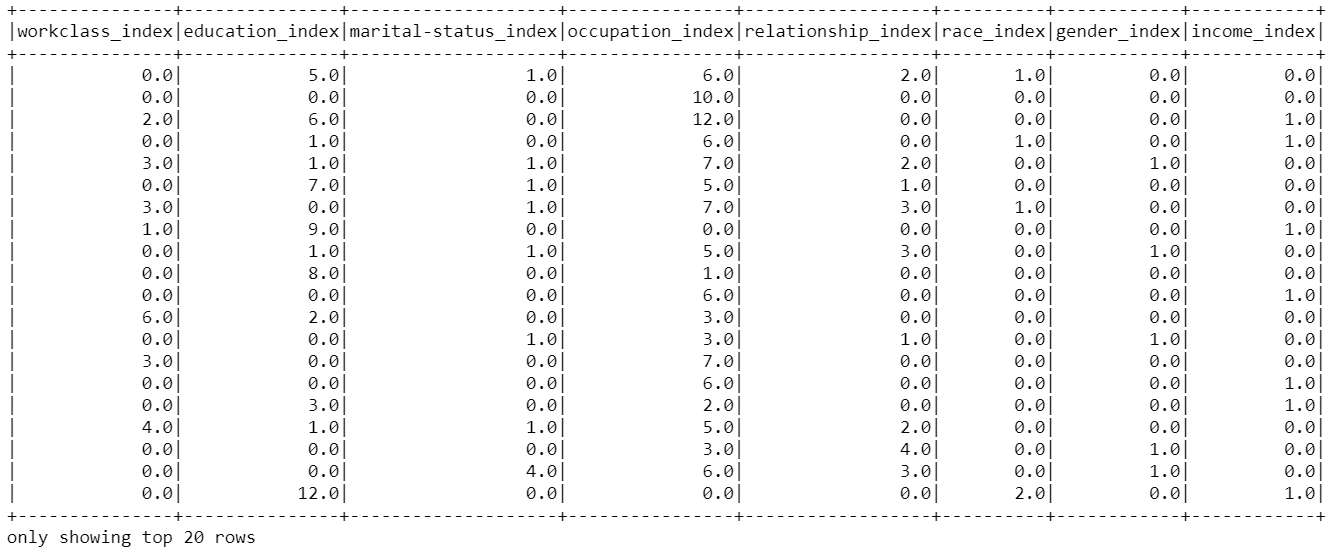

In [36]:
#Define the input columns
inputCols=[x for x in df.columns]
#Define the output columns 
outputCols=[f'{x}_index' for x in df.columns]
print(outputCols)

# TODO: Initialize StringIndexer (use inputCols and outputCols)
indexer = StringIndexer(inputCols=inputCols,outputCols=outputCols)

#TODO call the fit and transform() method to get the encoded results 
df_indexed = indexer.fit(df).transform(df)

#TODO Display the output, only the output columns
df_indexed.select(outputCols).show()


['workclass_index', 'education_index', 'marital-status_index', 'occupation_index', 'relationship_index', 'race_index', 'gender_index', 'income_index']
+---------------+---------------+--------------------+----------------+------------------+----------+------------+------------+
|workclass_index|education_index|marital-status_index|occupation_index|relationship_index|race_index|gender_index|income_index|
+---------------+---------------+--------------------+----------------+------------------+----------+------------+------------+
|            0.0|            5.0|                 1.0|             6.0|               2.0|       1.0|         0.0|         0.0|
|            0.0|            0.0|                 0.0|            10.0|               0.0|       0.0|         0.0|         0.0|
|            2.0|            6.0|                 0.0|            12.0|               0.0|       0.0|         0.0|         1.0|
|            0.0|            1.0|                 0.0|             6.0|          

### One Hot Encoder (OHE) <a class="anchor" name="ohe"></a>
One hot encoding is representation of categorical variables as binary vectors. It works in 2 steps:
1. The categorical variables are mapped as integer values
2. Each integer value is represented as binary vector

<a href="https://spark.apache.org/docs/latest/ml-features.html#onehotencoder" target="_BLANK">[Spark References] </a>
<a href="https://machinelearningmastery.com/how-to-one-hot-encode-sequence-data-in-python" target="_BLANK"> [Read More]</a>

<div style="background:rgba(0,109,174,0.2);padding:10px;border-radius:4px">
    <strong style="color:#006DAE">NOTE: </strong><code>OneHotEncoder</code> in Spark does not directly encode the categorical variable. We have converted the categorical variable to numerical using <code>StringIndexer</code> in the above step. Now we can implement the <code>OHE</code> to the <em>numerical columns</em> obtained from the step above.
    </div>

In [30]:
#Example of OHE from Spark Documentation
from pyspark.ml.feature import OneHotEncoder

df_ref = spark.createDataFrame([
    (0.0, 1.0),
    (1.0, 0.0),
    (2.0, 1.0),
    (0.0, 2.0),
    (0.0, 1.0),
    (2.0, 0.0)
], ["categoryIndex1", "categoryIndex2"])

encoder = OneHotEncoder(inputCols=["categoryIndex1", "categoryIndex2"],
                        outputCols=["categoryVec1", "categoryVec2"])
model = encoder.fit(df_ref)
encoded = model.transform(df_ref)
encoded.show()

+--------------+--------------+-------------+-------------+
|categoryIndex1|categoryIndex2| categoryVec1| categoryVec2|
+--------------+--------------+-------------+-------------+
|           0.0|           1.0|(2,[0],[1.0])|(2,[1],[1.0])|
|           1.0|           0.0|(2,[1],[1.0])|(2,[0],[1.0])|
|           2.0|           1.0|    (2,[],[])|(2,[1],[1.0])|
|           0.0|           2.0|(2,[0],[1.0])|    (2,[],[])|
|           0.0|           1.0|(2,[0],[1.0])|(2,[1],[1.0])|
|           2.0|           0.0|    (2,[],[])|(2,[0],[1.0])|
+--------------+--------------+-------------+-------------+



<a class="anchor" id="lab-task-3"></a>
<div style="background:rgba(0,109,174,0.2);padding:10px;border-radius:4px"><strong style="color:#FF5555">3. Lab Task: </strong>
    Apply <code>OneHotEncoder</code> transformation to all numerical columns in the dataframe. We shouldn't be including the <strong>target</strong> column i.e. <code>income</code> anymore here. We just want to include the features.
</div><br/>

In [37]:
#WRITE THE CODE WHERE NECESSARY
# https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.feature.OneHotEncoder.html#pyspark.ml.feature.OneHotEncoder

#the outputcols of previous step act as input cols for this step
inputCols_OHE = [x for x in outputCols if x!='income_index']  #all output columns from StringIndexer exept the Income
outputCols_OHE = [f'{x}_vec' for x in inputCols if x!='income']

#Define OneHotEncoder with the appropriate columns
encoder = OneHotEncoder(inputCols=inputCols_OHE,
                        outputCols=outputCols_OHE)

# Call fit and transform to get the encoded results
model = encoder.fit(df_indexed)
df_encoded = model.transform(df_indexed) 

#Display the output columns
df_encoded.select(outputCols_OHE).show()


+-------------+---------------+------------------+---------------+----------------+-------------+-------------+
|workclass_vec|  education_vec|marital-status_vec| occupation_vec|relationship_vec|     race_vec|   gender_vec|
+-------------+---------------+------------------+---------------+----------------+-------------+-------------+
|(8,[0],[1.0])| (15,[5],[1.0])|     (6,[1],[1.0])| (14,[6],[1.0])|   (5,[2],[1.0])|(4,[1],[1.0])|(1,[0],[1.0])|
|(8,[0],[1.0])| (15,[0],[1.0])|     (6,[0],[1.0])|(14,[10],[1.0])|   (5,[0],[1.0])|(4,[0],[1.0])|(1,[0],[1.0])|
|(8,[2],[1.0])| (15,[6],[1.0])|     (6,[0],[1.0])|(14,[12],[1.0])|   (5,[0],[1.0])|(4,[0],[1.0])|(1,[0],[1.0])|
|(8,[0],[1.0])| (15,[1],[1.0])|     (6,[0],[1.0])| (14,[6],[1.0])|   (5,[0],[1.0])|(4,[1],[1.0])|(1,[0],[1.0])|
|(8,[3],[1.0])| (15,[1],[1.0])|     (6,[1],[1.0])| (14,[7],[1.0])|   (5,[2],[1.0])|(4,[0],[1.0])|    (1,[],[])|
|(8,[0],[1.0])| (15,[7],[1.0])|     (6,[1],[1.0])| (14,[5],[1.0])|   (5,[1],[1.0])|(4,[0],[1.0])|(1,[0],

In [32]:
# number of distinct elements in column 'workclass'
print(df_adult.select('workclass').distinct().count())


9


### Expected output
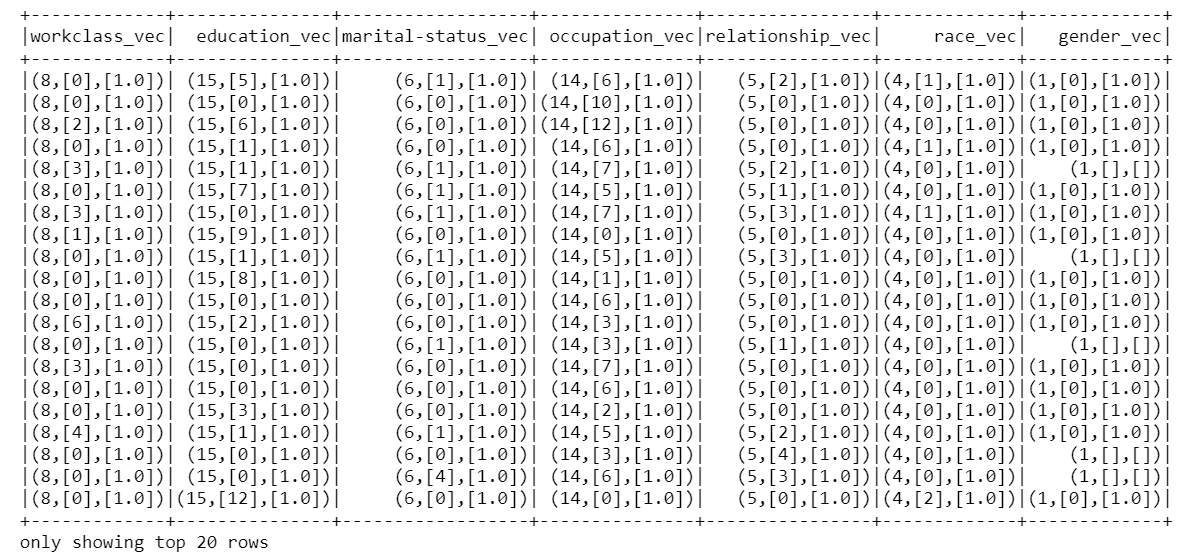

#### Rename the target column to label
<code>label</code> is popularly used as the name for the target variable. In supervised learning, we have a <strong>labelled</strong> dataset which is why the column name <strong>label</strong> makes sense.

In [33]:
df_encoded=df_encoded.withColumnRenamed('income_index', 'label')

### VectorAssembler <a class="anchor" name="vector-assembler"></a>
Finally, once we have transformed the data, we want to combine all the features into a single feature column to train the machine learning model. <code>VectorAssembler</code> combines the given list of columns to a <em>single vector</em> column.
<a href="https://spark.apache.org/docs/latest/ml-features.html#vectorassembler" target="_BLANK">[Spark Ref]</a>

In [34]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

dataset = spark.createDataFrame(
    [(0, 18, 1.0, Vectors.dense([0.0, 10.0, 0.5]), 1.0)],
    ["id", "hour", "mobile", "userFeatures", "clicked"])

assembler = VectorAssembler(
    inputCols=["hour", "mobile", "userFeatures"],
    outputCol="features")

output = assembler.transform(dataset)
print("Assembled columns 'hour', 'mobile', 'userFeatures' to vector column 'features'")
output.select("features", "clicked").show(truncate=False)

Assembled columns 'hour', 'mobile', 'userFeatures' to vector column 'features'
+-----------------------+-------+
|features               |clicked|
+-----------------------+-------+
|[18.0,1.0,0.0,10.0,0.5]|1.0    |
+-----------------------+-------+



<a class="anchor" id="lab-task-4"></a>
<div style="background:rgba(0,109,174,0.2);padding:10px;border-radius:4px"><strong style="color:#FF5555">4. Lab Task: </strong>
    Referring to the example above, use <code>VectorAssembler</code> to combine the feature columns from <b>Task 2</b> to a single column named <strong>features</strong>.
</div>

In [41]:
#WRITE THE CODE WHERE NECESSARY
inputCols= outputCols_OHE #the output columns from Task 3 i.e. OHE

#Define the assembler with appropriate input and output columns
assembler = VectorAssembler(inputCols=inputCols,outputCol="features")

#use the asseembler transform() to get encoded results
df_final = assembler.transform(df_encoded)
#Display the output
df_final.select('features').show(truncate=False)


+--------------------------------------------------------+
|features                                                |
+--------------------------------------------------------+
|(53,[0,13,24,35,45,49,52],[1.0,1.0,1.0,1.0,1.0,1.0,1.0])|
|(53,[0,8,23,39,43,48,52],[1.0,1.0,1.0,1.0,1.0,1.0,1.0]) |
|(53,[2,14,23,41,43,48,52],[1.0,1.0,1.0,1.0,1.0,1.0,1.0])|
|(53,[0,9,23,35,43,49,52],[1.0,1.0,1.0,1.0,1.0,1.0,1.0]) |
|(53,[3,9,24,36,45,48],[1.0,1.0,1.0,1.0,1.0,1.0])        |
|(53,[0,15,24,34,44,48,52],[1.0,1.0,1.0,1.0,1.0,1.0,1.0])|
|(53,[3,8,24,36,46,49,52],[1.0,1.0,1.0,1.0,1.0,1.0,1.0]) |
|(53,[1,17,23,29,43,48,52],[1.0,1.0,1.0,1.0,1.0,1.0,1.0])|
|(53,[0,9,24,34,46,48],[1.0,1.0,1.0,1.0,1.0,1.0])        |
|(53,[0,16,23,30,43,48,52],[1.0,1.0,1.0,1.0,1.0,1.0,1.0])|
|(53,[0,8,23,35,43,48,52],[1.0,1.0,1.0,1.0,1.0,1.0,1.0]) |
|(53,[6,10,23,32,43,48,52],[1.0,1.0,1.0,1.0,1.0,1.0,1.0])|
|(53,[0,8,24,32,44,48],[1.0,1.0,1.0,1.0,1.0,1.0])        |
|(53,[3,8,23,36,43,48,52],[1.0,1.0,1.0,1.0,1.0,1.0,1.0])

### ML Algorithm and Prediction <a class="anchor" name="ml-algorithm"></a>
Here we are using Logistic Regression for the classification. We will explore the details about this algorithm in the next tutorials. Please refer to the <a href="https://spark.apache.org/docs/latest/ml-classification-regression.html#logistic-regression" target="_BLANK">[Spark Docs]</a> for further reference.

In [ ]:
#Splitting the data into testing and training set 90% into training and 10% for testing
train, test = df_final.randomSplit([0.9, 0.1])

In [ ]:
#Implementing the Logistic Regression
from pyspark.ml.classification import LogisticRegression

# Create a LogisticRegression instance. This instance is an Estimator.
lr = LogisticRegression(featuresCol='features',labelCol='label')
model = lr.fit(train)

In [ ]:
#Here we use the model trained with the training data to give predictions for our test data
predicted_data = model.transform(test)
predicted_data.select('features','label','prediction').filter(predicted_data.label==1).show()

In [ ]:
#This gives the accuracy of the model we have built, 
trainingSummary = model.summary
trainingSummary.accuracy

<div style="background:rgba(0,109,174,0.2);padding:10px;border-radius:4px">
    <strong style="color:#006DAE">NOTE: </strong>What is your interpretation about the accuracy of the model?
    </div>

## Pipeline API <a class="anchor" name="pipeline"></a>
In machine learning, it is common to run a sequence of algorithms to process and learn from data. We have seen in the example above, there is a sequence of steps to be done to prepare the data for training.
Such sequence of steps in Spark can be reqpresented by a Pipeline, which consists of a sequence of PipelineStages (Transformers and Estimators) to be run in a specific order. We will try to convert the above sequence of transformers and estimators into a Pipeline.
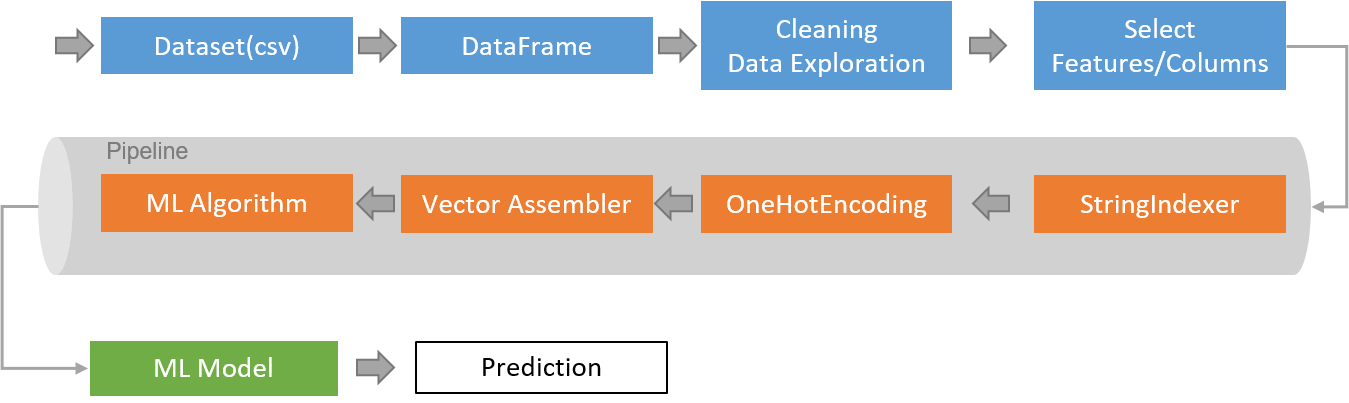
In the figure above, we can the steps <code>StringIndexer, OneHotEncoder, VectorAssembler and MLAlgorithm</code> are plugged into the pipeline.

#### Pipeline API Example <a class="anchor" name="pipeline-example"></a>
An example demonstrating the use of <code>Pipeline</code> taken from <a href="https://spark.apache.org/docs/latest/ml-pipeline.html#example-pipeline" target="_BLANK">[Spark Docs]</a> is given below.
Go through this example to implement your own <code>Pipeline</code> for <strong>Task 5</strong>.

In [55]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import HashingTF, Tokenizer

# Prepare training documents from a list of (id, text, label) tuples.
training = spark.createDataFrame([
    (0, "win million dollar", 1.0),
    (1, "Office meeting", 0.0),
    (2, "Do not miss this opportunity", 1.0),
    (3, "update your password", 1.0),
    (4, "Assignment submission", 0.0)
], ["id", "text", "label"])

# Prepare test documents, which are unlabeled (id, text) tuples.
test = spark.createDataFrame([
    (5, "get bonus of 200 dollars"),
    (6, "change your bank password"),
    (7, "Next meeting is at 5pm"),
    (8, "Late submission"),
    (9, "Daily newsletter")
], ["id", "text"])

training.show()
test.show()

# Configure an ML pipeline, which consists of three stages: tokenizer, hashingTF, and lr.
tokenizer = Tokenizer(inputCol="text", outputCol="words")
hashingTF = HashingTF(inputCol=tokenizer.getOutputCol(), outputCol="features")
lr = LogisticRegression(maxIter=10, regParam=0.001)
pipeline = Pipeline(stages=[tokenizer, hashingTF, lr])

# Fit the pipeline to training documents.
model = pipeline.fit(training)

# Make predictions on test documents and print columns of interest.
prediction = model.transform(test)
prediction.show()

selected = prediction.select("id", "text", "probability", "prediction")
for row in selected.collect():
    rid, text, prob, prediction = row
    print("(%d, %s) --> prob=%s, prediction=%f" % (rid, text, str(prob), prediction))


+---+--------------------+-----+
| id|                text|label|
+---+--------------------+-----+
|  0|  win million dollar|  1.0|
|  1|      Office meeting|  0.0|
|  2|Do not miss this ...|  1.0|
|  3|update your password|  1.0|
|  4|Assignment submis...|  0.0|
+---+--------------------+-----+

+---+--------------------+
| id|                text|
+---+--------------------+
|  5|get bonus of 200 ...|
|  6|change your bank ...|
|  7|Next meeting is a...|
|  8|     Late submission|
|  9|    Daily newsletter|
+---+--------------------+

+---+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
| id|                text|               words|            features|       rawPrediction|         probability|prediction|
+---+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|  5|get bonus of 200 ...|[get, bonus, of, ...|(262144,[4978,555...|[-0.1736459066914...|[0.

### Congratulations on finishing this activity. See you next week.